In [1]:
import pandas as pd
df = pd.read_csv('spanish_2024_race_laps.csv')
df


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 00:58:20.507000,VER,1,0 days 00:01:23.186000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:32.054000,...,False,Red Bull Racing,0 days 00:56:57.095000,2024-06-23 13:03:14.413,1,2.0,False,NaN,False,False
1,0 days 00:59:40.378000,VER,1,0 days 00:01:19.871000,2.0,1.0,NaN,NaN,0 days 00:00:24.201000,0 days 00:00:31.900000,...,False,Red Bull Racing,0 days 00:58:20.507000,2024-06-23 13:04:37.825,1,2.0,False,NaN,False,True
2,0 days 01:00:59.742000,VER,1,0 days 00:01:19.364000,3.0,1.0,NaN,NaN,0 days 00:00:23.249000,0 days 00:00:32.086000,...,False,Red Bull Racing,0 days 00:59:40.378000,2024-06-23 13:05:57.696,1,1.0,False,NaN,False,True
3,0 days 01:02:20.508000,VER,1,0 days 00:01:20.766000,4.0,1.0,NaN,NaN,0 days 00:00:24.251000,0 days 00:00:32.339000,...,False,Red Bull Racing,0 days 01:00:59.742000,2024-06-23 13:07:17.060,1,1.0,False,NaN,False,True
4,0 days 01:03:41.335000,VER,1,0 days 00:01:20.827000,5.0,1.0,NaN,NaN,0 days 00:00:24.165000,0 days 00:00:32.393000,...,False,Red Bull Racing,0 days 01:02:20.508000,2024-06-23 13:08:37.826,1,1.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,0 days 02:19:52.918000,SAR,2,0 days 00:01:24.685000,60.0,3.0,NaN,NaN,0 days 00:00:24.072000,0 days 00:00:34.369000,...,True,Williams,0 days 02:18:28.233000,2024-06-23 14:24:45.551,1,20.0,False,NaN,False,True
1306,0 days 02:21:14.223000,SAR,2,0 days 00:01:21.305000,61.0,3.0,NaN,NaN,0 days 00:00:23.892000,0 days 00:00:32.790000,...,True,Williams,0 days 02:19:52.918000,2024-06-23 14:26:10.236,1,20.0,False,NaN,False,True
1307,0 days 02:22:35.599000,SAR,2,0 days 00:01:21.376000,62.0,3.0,NaN,NaN,0 days 00:00:23.876000,0 days 00:00:32.868000,...,True,Williams,0 days 02:21:14.223000,2024-06-23 14:27:31.541,1,20.0,False,NaN,False,True
1308,0 days 02:23:57.211000,SAR,2,0 days 00:01:21.612000,63.0,3.0,NaN,NaN,0 days 00:00:23.920000,0 days 00:00:32.884000,...,True,Williams,0 days 02:22:35.599000,2024-06-23 14:28:52.917,1,20.0,False,NaN,False,True


In [2]:
df['LapTime'] = pd.to_timedelta(df['LapTime'], errors='coerce')
df['LapTimeSeconds'] = df['LapTime'].dt.total_seconds()

In [3]:
voltas_completadas = df.groupby('Driver')['LapNumber'].max()
num_voltas_corrida = 66  # exemplo para Abu Dhabi 2024
limite_conclusao = 0.9 * num_voltas_corrida

concluiu = voltas_completadas >= limite_conclusao

df_features = pd.DataFrame({
    'Driver': voltas_completadas.index,
    'VoltasCompletadasDadosBrutos': voltas_completadas.values,
    'Concluiu': concluiu.values
})

# Resetar o índice para manter um DataFrame limpo
df_features.reset_index(drop=True, inplace=True)

In [4]:
import pandas as pd
import numpy as np

# 1. Criar pits_df com voltas que tem PitInTime ou PitOutTime (opcional, só para pegar dados importantes)
pits_df = df[df['PitInTime'].notna() | df['PitOutTime'].notna()]
pits_df = pits_df[['Driver', 'LapNumber', 'PitInTime', 'PitOutTime', 'Compound', 'TyreLife', 'Stint']]
pits_df = pits_df.sort_values(['Driver', 'LapNumber']).reset_index(drop=True)

# 2. Número de paradas no box por piloto = número de stints - 1
num_stints = df.groupby('Driver')['Stint'].nunique()
pit_counts = (num_stints - 1).rename('NumParadasBox')

# 3. Volta do primeiro pit stop por piloto — pegar a menor volta onde mudou o stint (ou a primeira volta do segundo stint)
# Para isso, pegar a volta mínima para cada piloto onde o stint é > 1
primeiro_pit = df[df['Stint'] > 1].groupby('Driver')['LapNumber'].min().rename('VoltaPrimeiroPit')

# 4. Duração média dos stints por piloto (número médio de voltas por stint)
stint_dur = df.groupby(['Driver', 'Stint']).size().groupby('Driver').mean().rename('DuracaoMediaStint')

# 5. Proporção de voltas por tipo de pneu
voltas_totais = df.groupby('Driver').size()

prop_soft = df[df['Compound'] == 'SOFT'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMacios')
prop_medium = df[df['Compound'] == 'MEDIUM'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasMedios')
prop_hard = df[df['Compound'] == 'HARD'].groupby('Driver').size().divide(voltas_totais).rename('PropVoltasDuros')

# 6. Juntar tudo num DataFrame
df_pit_features = pd.concat([
    pit_counts,
    primeiro_pit,
    stint_dur,
    prop_soft,
    prop_medium,
    prop_hard
], axis=1).reset_index()

# Substituir NaNs por 0 para pilotos sem dados em algumas colunas
df_pit_features.fillna({
    'NumParadasBox': 0,
    'VoltaPrimeiroPit': 0,
    'DuracaoMediaStint': 0,
    'PropVoltasMacios': 0,
    'PropVoltasMedios': 0,
    'PropVoltasDuros': 0
}, inplace=True)

print(df_pit_features.head())


  Driver  NumParadasBox  VoltaPrimeiroPit  DuracaoMediaStint  \
0    ALB              2              19.0          21.666667   
1    ALO              2              20.0          21.666667   
2    BOT              2              12.0          21.666667   
3    GAS              2              15.0          22.000000   
4    HAM              2              17.0          22.000000   

   PropVoltasMacios  PropVoltasMedios  PropVoltasDuros  
0          0.723077          0.276923         0.000000  
1          0.292308          0.400000         0.307692  
2          0.430769          0.000000         0.569231  
3          0.212121          0.363636         0.424242  
4          0.590909          0.409091         0.000000  


In [5]:
pits_df

,Driver,LapNumber,PitInTime,PitOutTime,Compound,TyreLife,Stint
0,ALB,1.0,NaN,0 days 00:57:07.090000,MEDIUM,1.0,1.0
1,ALB,18.0,0 days 01:21:58.483000,NaN,MEDIUM,18.0,1.0
2,ALB,19.0,NaN,0 days 01:22:21.666000,SOFT,1.0,2.0
3,ALB,43.0,0 days 01:56:17.090000,NaN,SOFT,25.0,2.0
4,ALB,44.0,NaN,0 days 01:56:38.873000,SOFT,1.0,3.0
...,...,...,...,...,...,...,...
80,VER,45.0,NaN,0 days 01:56:35.276000,SOFT,1.0,3.0
81,ZHO,9.0,0 days 01:09:30.287000,NaN,SOFT,9.0,1.0
82,ZHO,10.0,NaN,0 days 01:09:52.752000,MEDIUM,1.0,2.0
83,ZHO,41.0,0 days 01:53:14.586000,NaN,MEDIUM,32.0,2.0


In [6]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,19.0,21.666667,0.723077,0.276923,0.000000
1,ALO,2,20.0,21.666667,0.292308,0.400000,0.307692
2,BOT,2,12.0,21.666667,0.430769,0.000000,0.569231
3,GAS,2,15.0,22.000000,0.212121,0.363636,0.424242
4,HAM,2,17.0,22.000000,0.590909,0.409091,0.000000
5,HUL,2,13.0,22.000000,0.181818,0.393939,0.424242
6,LEC,2,25.0,22.000000,0.651515,0.348485,0.000000
7,MAG,2,11.0,21.666667,0.153846,0.292308,0.553846
8,NOR,2,24.0,22.000000,0.636364,0.363636,0.000000
9,OCO,2,14.0,22.000000,0.196970,0.363636,0.439394


In [7]:
df = df[df['IsAccurate']]


In [8]:
df['IsAccurate'].value_counts()


,count
IsAccurate,
True,1206


In [9]:
df['Driver'].value_counts()


,count
Driver,
VER,61
NOR,61
HAM,61
RUS,61
LEC,61
SAI,61
PIA,61
GAS,61
HUL,61


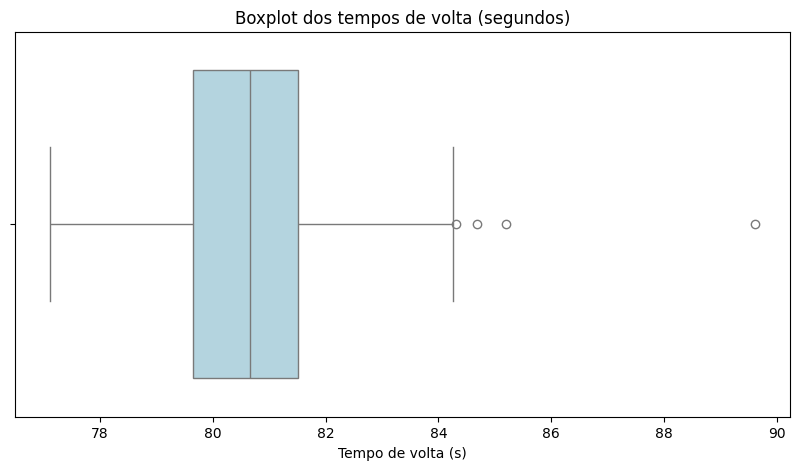

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['LapTimeSeconds'], color='lightblue')
plt.title('Boxplot dos tempos de volta (segundos)')
plt.xlabel('Tempo de volta (s)')
plt.show()


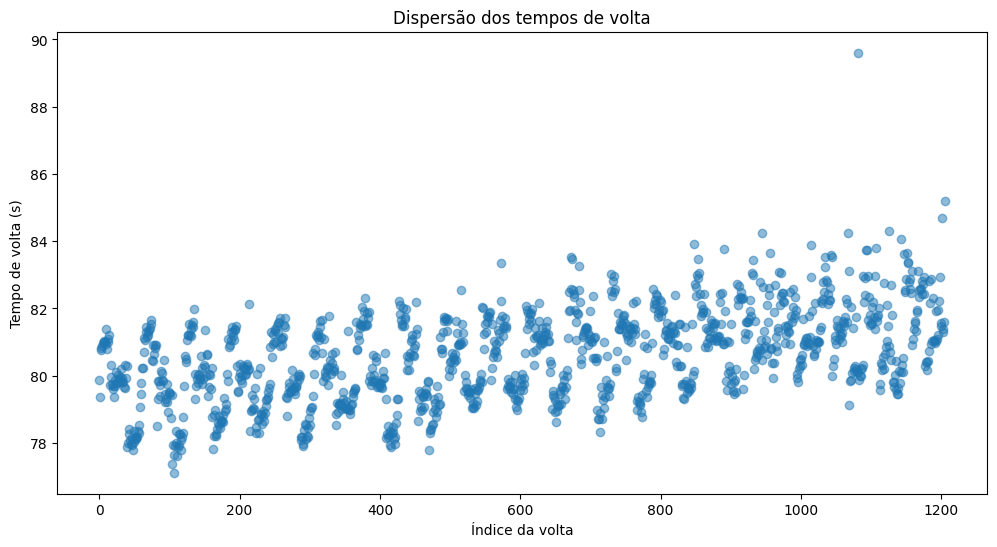

In [11]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(df)), df['LapTimeSeconds'], alpha=0.5)
plt.title('Dispersão dos tempos de volta')
plt.xlabel('Índice da volta')
plt.ylabel('Tempo de volta (s)')
plt.show()


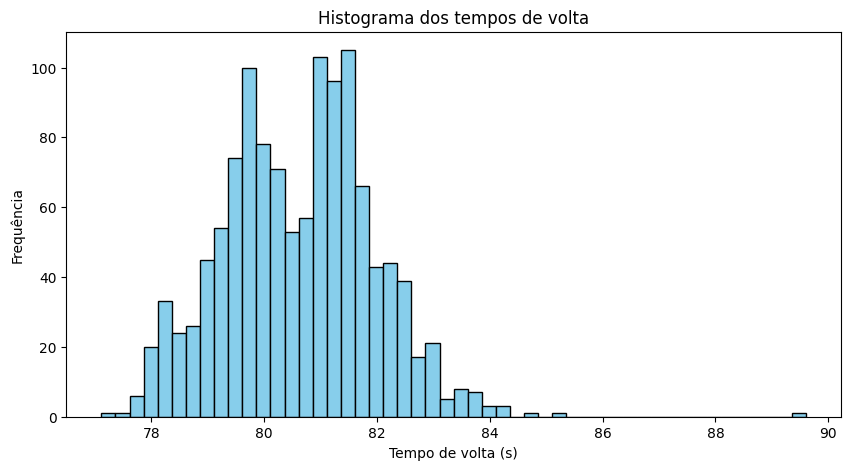

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df['LapTimeSeconds'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histograma dos tempos de volta')
plt.xlabel('Tempo de volta (s)')
plt.ylabel('Frequência')
plt.show()


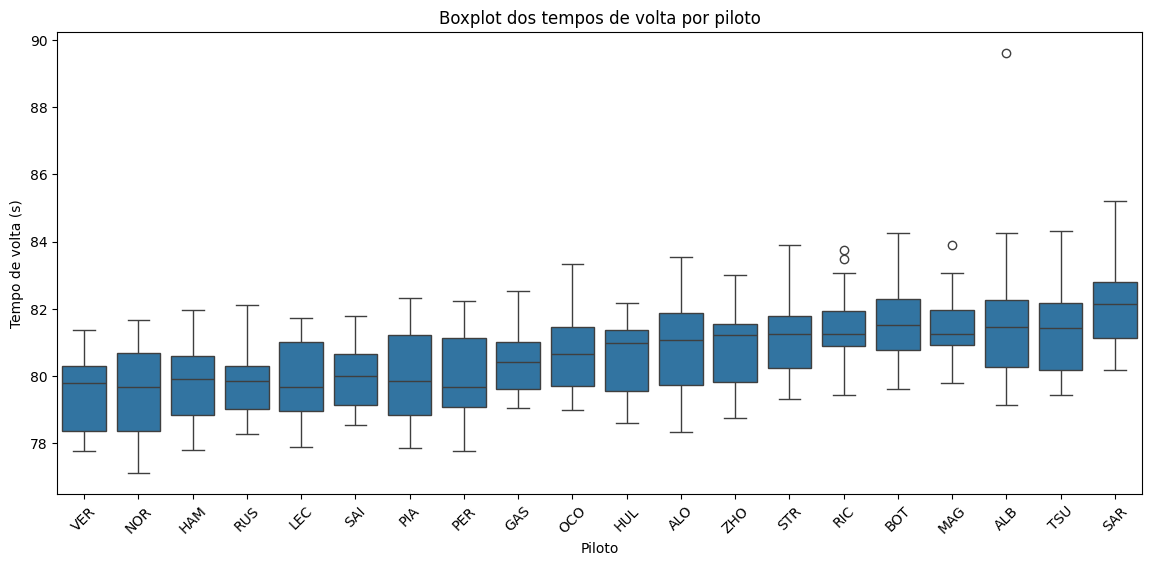

In [13]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='Driver', y='LapTimeSeconds', data=df)
plt.title('Boxplot dos tempos de volta por piloto')
plt.xlabel('Piloto')
plt.ylabel('Tempo de volta (s)')
plt.xticks(rotation=45)
plt.show()


In [14]:
menor_volta_por_piloto = df.groupby('Driver')['LapTime'].min().sort_values()
print(menor_volta_por_piloto)


Driver
NOR   0 days 00:01:17.115000
VER   0 days 00:01:17.776000
PER   0 days 00:01:17.785000
HAM   0 days 00:01:17.809000
PIA   0 days 00:01:17.874000
LEC   0 days 00:01:17.897000
RUS   0 days 00:01:18.290000
ALO   0 days 00:01:18.334000
SAI   0 days 00:01:18.539000
HUL   0 days 00:01:18.609000
ZHO   0 days 00:01:18.771000
OCO   0 days 00:01:18.982000
GAS   0 days 00:01:19.045000
ALB   0 days 00:01:19.132000
STR   0 days 00:01:19.318000
TSU   0 days 00:01:19.447000
RIC   0 days 00:01:19.450000
BOT   0 days 00:01:19.608000
MAG   0 days 00:01:19.805000
SAR   0 days 00:01:20.172000
Name: LapTime, dtype: timedelta64[ns]


In [15]:
year = 2024
grand_prix = 'Espanha'
race_date = '2024-06-23'  # ex: usar o dado do evento ou da sessão

# Calcular métricas por piloto (como antes)
consistency_df = df.groupby('Driver')['LapTimeSeconds'].agg([
    'count',
    'mean',
    'std',
    'min',
    'max',
    'median'
]).rename(columns={
    'count': 'NumVoltas',
    'mean': 'MediaTempo',
    'std': 'DesvioPadrao',
    'min': 'MelhorVolta',
    'max': 'PiorVolta',
    'median': 'MedianaTempo'
})

consistency_df['RangeTempo'] = consistency_df['PiorVolta'] - consistency_df['MelhorVolta']

# Adicionar colunas fixas
consistency_df['Year'] = year
consistency_df['GrandPrix'] = grand_prix
consistency_df['RaceDate'] = race_date

# Resetar índice para 'Driver' virar coluna normal
consistency_df = consistency_df.reset_index()


In [16]:
consistency_df

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate
0,ALB,60,81.567550,1.568417,79.132,89.605,81.4535,10.473,2024,Espanha,2024-06-23
1,ALO,60,80.902783,1.288998,78.334,83.536,81.0715,5.202,2024,Espanha,2024-06-23
2,BOT,60,81.563117,0.994920,79.608,84.249,81.5095,4.641,2024,Espanha,2024-06-23
3,GAS,61,80.399328,0.894914,79.045,82.534,80.4190,3.489,2024,Espanha,2024-06-23
4,HAM,61,79.835000,1.051148,77.809,81.977,79.9150,4.168,2024,Espanha,2024-06-23
5,HUL,61,80.567279,1.012017,78.609,82.174,80.9720,3.565,2024,Espanha,2024-06-23
6,LEC,61,79.876016,1.181131,77.897,81.723,79.6750,3.826,2024,Espanha,2024-06-23
7,MAG,60,81.414983,0.843031,79.805,83.892,81.2555,4.087,2024,Espanha,2024-06-23
8,NOR,61,79.598738,1.268696,77.115,81.660,79.6820,4.545,2024,Espanha,2024-06-23
9,OCO,61,80.596607,0.999434,78.982,83.348,80.6620,4.366,2024,Espanha,2024-06-23


In [17]:
# Juntar os dois DataFrames pela coluna 'Driver'
df_final = consistency_df.merge(df_features, on='Driver', how='inner')


In [18]:
df_final

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu
0,ALB,60,81.567550,1.568417,79.132,89.605,81.4535,10.473,2024,Espanha,2024-06-23,65.0,True
1,ALO,60,80.902783,1.288998,78.334,83.536,81.0715,5.202,2024,Espanha,2024-06-23,65.0,True
2,BOT,60,81.563117,0.994920,79.608,84.249,81.5095,4.641,2024,Espanha,2024-06-23,65.0,True
3,GAS,61,80.399328,0.894914,79.045,82.534,80.4190,3.489,2024,Espanha,2024-06-23,66.0,True
4,HAM,61,79.835000,1.051148,77.809,81.977,79.9150,4.168,2024,Espanha,2024-06-23,66.0,True
5,HUL,61,80.567279,1.012017,78.609,82.174,80.9720,3.565,2024,Espanha,2024-06-23,66.0,True
6,LEC,61,79.876016,1.181131,77.897,81.723,79.6750,3.826,2024,Espanha,2024-06-23,66.0,True
7,MAG,60,81.414983,0.843031,79.805,83.892,81.2555,4.087,2024,Espanha,2024-06-23,65.0,True
8,NOR,61,79.598738,1.268696,77.115,81.660,79.6820,4.545,2024,Espanha,2024-06-23,66.0,True
9,OCO,61,80.596607,0.999434,78.982,83.348,80.6620,4.366,2024,Espanha,2024-06-23,66.0,True


In [19]:
df_pit_features

,Driver,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,2,19.0,21.666667,0.723077,0.276923,0.000000
1,ALO,2,20.0,21.666667,0.292308,0.400000,0.307692
2,BOT,2,12.0,21.666667,0.430769,0.000000,0.569231
3,GAS,2,15.0,22.000000,0.212121,0.363636,0.424242
4,HAM,2,17.0,22.000000,0.590909,0.409091,0.000000
5,HUL,2,13.0,22.000000,0.181818,0.393939,0.424242
6,LEC,2,25.0,22.000000,0.651515,0.348485,0.000000
7,MAG,2,11.0,21.666667,0.153846,0.292308,0.553846
8,NOR,2,24.0,22.000000,0.636364,0.363636,0.000000
9,OCO,2,14.0,22.000000,0.196970,0.363636,0.439394


In [20]:
df_completo = df_final.merge(df_pit_features, on='Driver', how='inner')


In [21]:
df_completo

,Driver,NumVoltas,MediaTempo,DesvioPadrao,MelhorVolta,PiorVolta,MedianaTempo,RangeTempo,Year,GrandPrix,RaceDate,VoltasCompletadasDadosBrutos,Concluiu,NumParadasBox,VoltaPrimeiroPit,DuracaoMediaStint,PropVoltasMacios,PropVoltasMedios,PropVoltasDuros
0,ALB,60,81.567550,1.568417,79.132,89.605,81.4535,10.473,2024,Espanha,2024-06-23,65.0,True,2,19.0,21.666667,0.723077,0.276923,0.000000
1,ALO,60,80.902783,1.288998,78.334,83.536,81.0715,5.202,2024,Espanha,2024-06-23,65.0,True,2,20.0,21.666667,0.292308,0.400000,0.307692
2,BOT,60,81.563117,0.994920,79.608,84.249,81.5095,4.641,2024,Espanha,2024-06-23,65.0,True,2,12.0,21.666667,0.430769,0.000000,0.569231
3,GAS,61,80.399328,0.894914,79.045,82.534,80.4190,3.489,2024,Espanha,2024-06-23,66.0,True,2,15.0,22.000000,0.212121,0.363636,0.424242
4,HAM,61,79.835000,1.051148,77.809,81.977,79.9150,4.168,2024,Espanha,2024-06-23,66.0,True,2,17.0,22.000000,0.590909,0.409091,0.000000
5,HUL,61,80.567279,1.012017,78.609,82.174,80.9720,3.565,2024,Espanha,2024-06-23,66.0,True,2,13.0,22.000000,0.181818,0.393939,0.424242
6,LEC,61,79.876016,1.181131,77.897,81.723,79.6750,3.826,2024,Espanha,2024-06-23,66.0,True,2,25.0,22.000000,0.651515,0.348485,0.000000
7,MAG,60,81.414983,0.843031,79.805,83.892,81.2555,4.087,2024,Espanha,2024-06-23,65.0,True,2,11.0,21.666667,0.153846,0.292308,0.553846
8,NOR,61,79.598738,1.268696,77.115,81.660,79.6820,4.545,2024,Espanha,2024-06-23,66.0,True,2,24.0,22.000000,0.636364,0.363636,0.000000
9,OCO,61,80.596607,0.999434,78.982,83.348,80.6620,4.366,2024,Espanha,2024-06-23,66.0,True,2,14.0,22.000000,0.196970,0.363636,0.439394


In [22]:
print("Shape final:", df_completo.shape)
print("Pilotos presentes:", df_completo['Driver'].nunique())


Shape final: (20, 19)
Pilotos presentes: 20


In [23]:
df_completo.to_csv('df_completoEspanha.csv', index=False)
